# LAB 5: Predicting diabetes aplication with decision trees on dataset with missing values

The purpuse of this lab is to continue your work from the previous lab on the Pima Indians Diabetes dataset provided in this folder and described below. You will do this by employing ensemble based algorithms presented in the lectures of previous weeks: Bagging, Random forests, Adaboost. 

## Tasks

1. Study the code with explanations and examples provided in this notebook. Try to understand each cell, run it and check the result. 

2. Experiment with other hyperparameter values of the ensemble based models seen in this lab.

3. Compare the performances of the ensemble models in this lab, with the best decision tree models you obtained in Lab week 5.

## Loading Libraries

In [1]:
# show plots inside the notebook  
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data Loading

In [2]:
diabetes_dataset = pd.read_csv("diabetes.csv")

Data Set Information:

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. 

Attribute Information:

1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years) 
9. Class variable (0 or 1) 

## Data Checking

In [3]:
diabetes_dataset.shape

(768, 9)

In [4]:
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
diabetes_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
diabetes_dataset.groupby("Outcome").size()

Outcome
0    500
1    268
dtype: int64

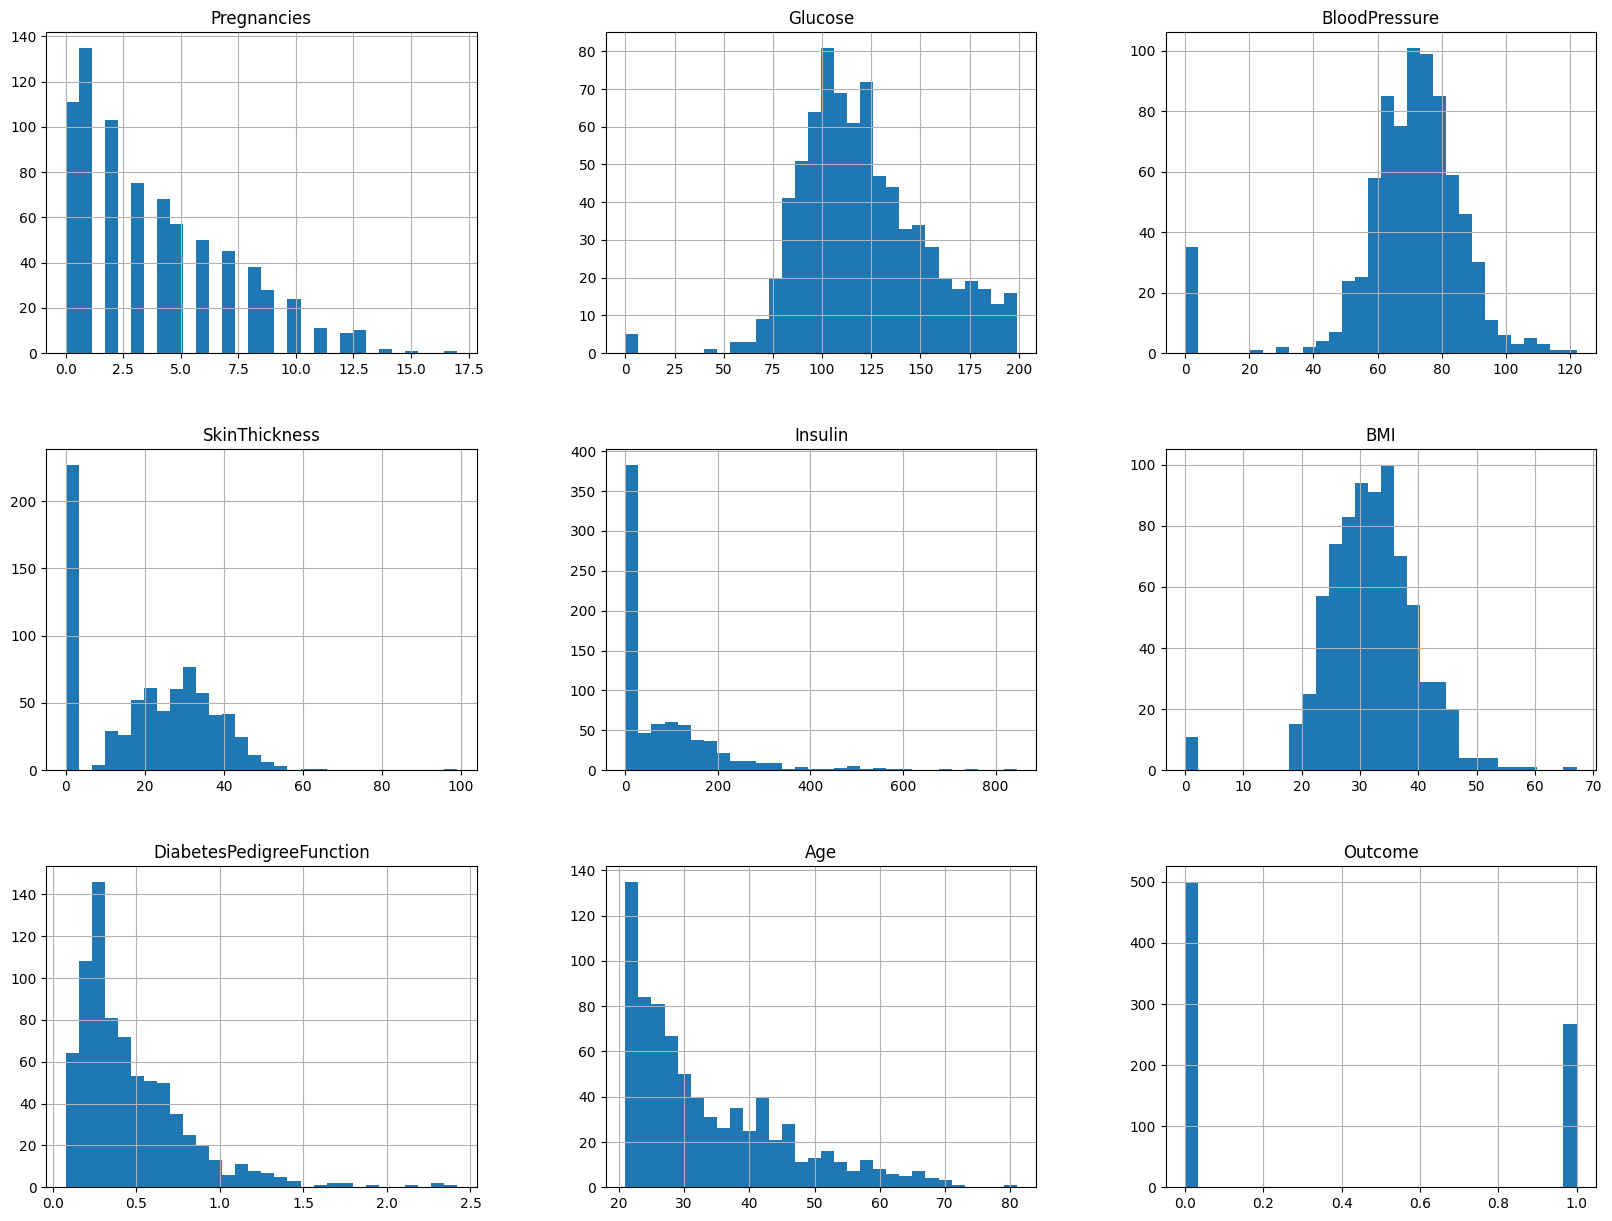

In [7]:
#check variable distributions
diabetes_dataset.hist(bins=30, figsize=(20,15))
plt.show()

Now we know that there are 768 people with an uneven distribution of the outcome (healthy:sick = 500:268). There are also some missing values (0s) for the variables 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' and 'BMI'.

## Some Data Cleaning

The dataset contains multiple (invalid) zero values. We are going to replace zeros with NAN.

In [8]:
# This replaces zero/invalid values with NANs.
dataset_nozeros = diabetes_dataset.copy()
zero_fields = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'] 
diabetes_dataset[zero_fields] = diabetes_dataset[zero_fields].replace(0, np.nan)
diabetes_dataset.describe()  # check that there are no invalid values left
diabetes_dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


## Data Stratification

When we split the dataset into train and test datasets, the split is completely random. Thus the instances of each class label or outcome in the train or test datasets is random. Thus we may have many instances of class 1 in training data and less instances of class 2 in the training data. So during classification, we may have accurate predictions for class1 but not for class2. Thus we stratify the data, so that we have proportionate data for all the classes in both the training and testing data.

In [9]:
from sklearn.model_selection import train_test_split 

# divide into training and testing data
train,test = train_test_split(diabetes_dataset, test_size=0.25, random_state=0, stratify=diabetes_dataset['Outcome']) 

# separate the 'Outcome' column from training/testing data
train_X = train[train.columns[:8]]
test_X = test[test.columns[:8]]
train_Y = train['Outcome']
test_Y = test['Outcome']

## Data imputation
We replace NAN with the mean on the column on the training set. Then we uses these means of the training set to impute the test set also. The test set shouldn't be used to infer or transform the training data (this would be data leakage, and may lead in certain situation to biased predictions; the test data should be used only after the model was completeley developped on the train set).

A simple imputation can be done also with the median (replacin mean with median in code below).

In [10]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
imputer.fit(train_X)
#here are the means per columns that are used for imputation
print('means per columns for imputation', imputer.statistics_)
# now perform the imputation on trainng set
train_X=imputer.transform(train_X)
# and imputation on test set
test_X=imputer.transform(test_X)
print('notice mean values appearing in the train set', train_X)

means per columns for imputation [  3.99652778 121.83187391  72.52631579  29.70959596 155.6959707
  32.31933216   0.47252951  33.71527778]
notice mean values appearing in the train set [[  1.          80.          74.         ...  30.           0.527
   22.        ]
 [  2.         119.          72.52631579 ...  19.6          0.832
   72.        ]
 [ 10.         115.          72.52631579 ...  32.31933216   0.261
   30.        ]
 ...
 [  3.          82.          70.         ...  21.1          0.389
   25.        ]
 [  4.         156.          75.         ...  48.3          0.238
   32.        ]
 [  0.         161.          50.         ...  21.9          0.254
   65.        ]]


# Experiment with ensemble based algorithms: Bagging, Random forests, Adaboost


Here are some recommendations on most important parameters for these algorithms. For more details on the usually larger lists of hyperparameters for a given algorithm, see sklearn documentation (google on the name of the class like RandomForestClassifier for random forests).

BaggingClassifier:
n_estimators - not really to tune, but choose large number to ensure prediction convergence and stability (example at least 100, or most of the times 500)

RandomForestClassifier:
max_features (by default square root of number of features)
n_estimators - normally choose large number of estimators (usually at least 500)

Look also into the feature importance extracted from random forests model. Useful in case you want to select the most important features to use in other algorithms which would not benefit of having many input variables (for various reasons such as computation lasts long, or prone to overfitting when many variables like in the case linear models). 

AdaBoostClassifier:
n_estimators,
learning_rate

# Bagging


In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
bg=BaggingClassifier(DecisionTreeClassifier())
scores=cross_val_score(bg, train_X, train_Y, scoring='accuracy', cv=5)
print('acuracy on the 5 folds', scores)
print('and their mean', np.mean(scores))

acuracy on the 5 folds [0.68965517 0.71304348 0.79130435 0.68695652 0.76521739]
and their mean 0.7292353823088455


In [13]:

# with a large numbe of estimators we usually get a stable good bagging model; here we evalate it in cross validation.
bg.n_estimators=100 # by default 10 estimators (trees) are used
scores=cross_val_score(bg, train_X, train_Y, scoring='accuracy', cv=5)
print('acuracy on the 5 folds', scores)
print('and their mean', np.mean(scores))

acuracy on the 5 folds [0.69827586 0.74782609 0.7826087  0.77391304 0.74782609]
and their mean 0.7500899550224888


In [18]:
# with a large numbe of estimators we usually get a stable good bagging model, so we don't do any model tuning here
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
bg.fit(train_X, train_Y)
pred_Y=bg.predict(test_X)

cm=confusion_matrix(test_Y, pred_Y) # confusion matrix
print('confusion matrix,  classes order is 0 and 1, actual values on rows, predicted values on columns \n', cm)
print('\n accuracy', accuracy_score(test_Y, pred_Y))
print('\n precision', precision_score(test_Y, pred_Y))
print('\n recall (sensitivity)', recall_score(test_Y, pred_Y))
print('\n f1', f1_score(test_Y, pred_Y))

confusion matrix,  classes order is 0 and 1, actual values on rows, predicted values on columns 
 [[108  17]
 [ 30  37]]

 accuracy 0.7552083333333334

 precision 0.6851851851851852

 recall (sensitivity) 0.5522388059701493

 f1 0.6115702479338844


# Random Forests

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
scores=cross_val_score(rf, train_X, train_Y, scoring='accuracy', cv=5)
print('acuracy on the 5 folds', scores)
print('and their mean', np.mean(scores))

acuracy on the 5 folds [0.68103448 0.76521739 0.7826087  0.75652174 0.77391304]
and their mean 0.7518590704647676


In [20]:
rf.max_features= 2
rf.n_estimators=500
scores=cross_val_score(rf, train_X, train_Y, scoring='accuracy', cv=5)
print('acuracy on the 5 folds', scores)
print('and their mean', np.mean(scores))

acuracy on the 5 folds [0.67241379 0.73043478 0.7826087  0.74782609 0.74782609]
and their mean 0.7362218890554723


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = [
     {'max_features': [2, 3, 4, 6]} ]

grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True,
                            n_jobs=-1)   # notice n_jobs is number of jobs to run in parallel; when -1, all the processor capacity is used

grid_search.fit(train_X, train_Y)
print('best parameter values', grid_search.best_params_)
print('best estimator', grid_search.best_estimator_)

# display performances per each repetition of cross validation
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.mean(mean_score), params)


best parameter values {'max_features': 6}
best estimator RandomForestClassifier(max_features=6, n_estimators=500)
0.7466416791604198 {'max_features': 2}
0.7379610194902548 {'max_features': 3}
0.7466116941529235 {'max_features': 4}
0.7483508245877062 {'max_features': 6}


In [22]:
# evaluate best model from the grid on the test set

best_rf=grid_search.best_estimator_
pred_Y=best_rf.predict(test_X)

cm=confusion_matrix(test_Y, pred_Y) # confusion matrix
print('confusion matrix,  classes order is 0 and 1, actual values on rows, predicted values on columns \n', cm)
print('\n accuracy', accuracy_score(test_Y, pred_Y))
print('\n precision', precision_score(test_Y, pred_Y))
print('\n recall (sensitivity)', recall_score(test_Y, pred_Y))
print('\n f1', f1_score(test_Y, pred_Y))


confusion matrix,  classes order is 0 and 1, actual values on rows, predicted values on columns 
 [[107  18]
 [ 28  39]]

 accuracy 0.7604166666666666

 precision 0.6842105263157895

 recall (sensitivity) 0.582089552238806

 f1 0.6290322580645161


# AdaBoost


In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ab=AdaBoostClassifier(DecisionTreeClassifier(max_depth=3))
scores=cross_val_score(rf, train_X, train_Y, scoring='accuracy', cv=5)
print('acuracy on the 5 folds', scores)
print('and their mean', np.mean(scores))

acuracy on the 5 folds [0.69827586 0.76521739 0.79130435 0.74782609 0.75652174]
and their mean 0.7518290854572715


In [24]:
ab.n_estimators=200
ab.learning_rate=0.5
scores=cross_val_score(rf, train_X, train_Y, scoring='accuracy', cv=5)
print('acuracy on the 5 folds', scores)
print('and their mean', np.mean(scores))

acuracy on the 5 folds [0.70689655 0.74782609 0.79130435 0.77391304 0.75652174]
and their mean 0.7552923538230885


In [25]:
from sklearn.model_selection import GridSearchCV
param_grid = {
     'n_estimators': np.arange(10,200,10),
     'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]
 }
grid_search = GridSearchCV(ab, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(train_X,train_Y)
grid_search.best_params_
print('best parameter values', grid_search.best_params_)
print('best estimator', grid_search.best_estimator_)

# display performances per each repetition of cross validation
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.mean(mean_score), params)



best parameter values {'learning_rate': 0.05, 'n_estimators': 30}
best estimator AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.05, n_estimators=30)
0.7169865067466267 {'learning_rate': 0.01, 'n_estimators': 10}
0.7169865067466267 {'learning_rate': 0.01, 'n_estimators': 20}
0.732623688155922 {'learning_rate': 0.01, 'n_estimators': 30}
0.7326386806596701 {'learning_rate': 0.01, 'n_estimators': 40}
0.732623688155922 {'learning_rate': 0.01, 'n_estimators': 50}
0.7361019490254873 {'learning_rate': 0.01, 'n_estimators': 60}
0.7378410794602698 {'learning_rate': 0.01, 'n_estimators': 70}
0.7396701649175413 {'learning_rate': 0.01, 'n_estimators': 80}
0.7431184407796101 {'learning_rate': 0.01, 'n_estimators': 90}
0.7396551724137931 {'learning_rate': 0.01, 'n_estimators': 100}
0.7517691154422789 {'learning_rate': 0.01, 'n_estimators': 110}
0.7483058470764617 {'learning_rate': 0.01, 'n_estimators': 120}
0.7483058470764616 {'learning_rate': 0.0

In [26]:
best_ab=grid_search.best_estimator_
pred_Y=best_rf.predict(test_X)

cm=confusion_matrix(test_Y, pred_Y) # confusion matrix
print('confusion matrix,  classes order is 0 and 1, actual values on rows, predicted values on columns \n', cm)
print('\n accuracy', accuracy_score(test_Y, pred_Y))
print('\n precision', precision_score(test_Y, pred_Y))
print('\n recall (sensitivity)', recall_score(test_Y, pred_Y))
print('\n f1', f1_score(test_Y, pred_Y))


confusion matrix,  classes order is 0 and 1, actual values on rows, predicted values on columns 
 [[107  18]
 [ 28  39]]

 accuracy 0.7604166666666666

 precision 0.6842105263157895

 recall (sensitivity) 0.582089552238806

 f1 0.6290322580645161


# Conclusion
The enseamble models perform in general better than single models as decision trees. In particular Adaboost and Random Forest performed better than Bagging and DT on this dataset. In general, depending on the dataset, ensemble models can take significantly longer to train and tune (here a few seconds for Adaboost). If computatin lasts longer (for hours) on larger datasets, try to diminish the number of folds  in CV and/or the grid search.